In [30]:
import torch
from ast import literal_eval
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import koreanize_matplotlib

pd.set_option('display.max_columns', None)

In [24]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

In [25]:
import pandas as pd
from ast import literal_eval

# 데이터 로드
dataset = pd.read_csv('../data/train_labeled.csv') 

records = []
for _, row in dataset.iterrows():
    # 1. problems 컬럼 파싱 (문자열일 경우 딕셔너리로 변환)
    problems = row['problems']
    if isinstance(problems, str):
        try:
            problems = literal_eval(problems)
        except:
            problems = {} # 파싱 실패 시 빈 딕셔너리
    
    # 2. 데이터 추출 (최상위 컬럼 우선, 없으면 problems 내부 확인)
    # 질문 내용
    q_text = row.get('question') if pd.notna(row.get('question')) else problems.get('question', "")
    
    # 질문 부가 정보 (question_plus)
    q_plus = row.get('question_plus') if pd.notna(row.get('question_plus')) else problems.get('question_plus', None)
    
    # 선택지 및 정답 (보통 problems 내부에 리스트/숫자로 존재)
    choices = problems.get('choices', [])
    answer = problems.get('answer', None)
    
    # 3. 레코드 생성
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': q_text,
        'choices': choices,
        'answer': answer,
        'question_plus': q_plus,
        'subject': row.get('subject', 'unknown'),
        'from': row.get('from', 'unknown')       
    }
    records.append(record)

# 데이터프레임 변환
df = pd.DataFrame(records)

# 결과 확인
print(f"평탄화 완료: 총 {len(df)}개의 문항")
display(df.head())

평탄화 완료: 총 2031개의 문항


,id,paragraph,question,choices,answer,question_plus,subject,from
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU


In [26]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
subject             0
from                0
dtype: int64


In [27]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
 6   subject        2031 non-null   object
 7   from           2031 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.1+ KB


/tmp/ipykernel_9190/3146528977.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='subject', data=df_dist, ax=axes[1, 0], order=subject_order, palette='magma')
/tmp/ipykernel_9190/3146528977.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer', data=df_dist, ax=axes[2, 0], palette='viridis')


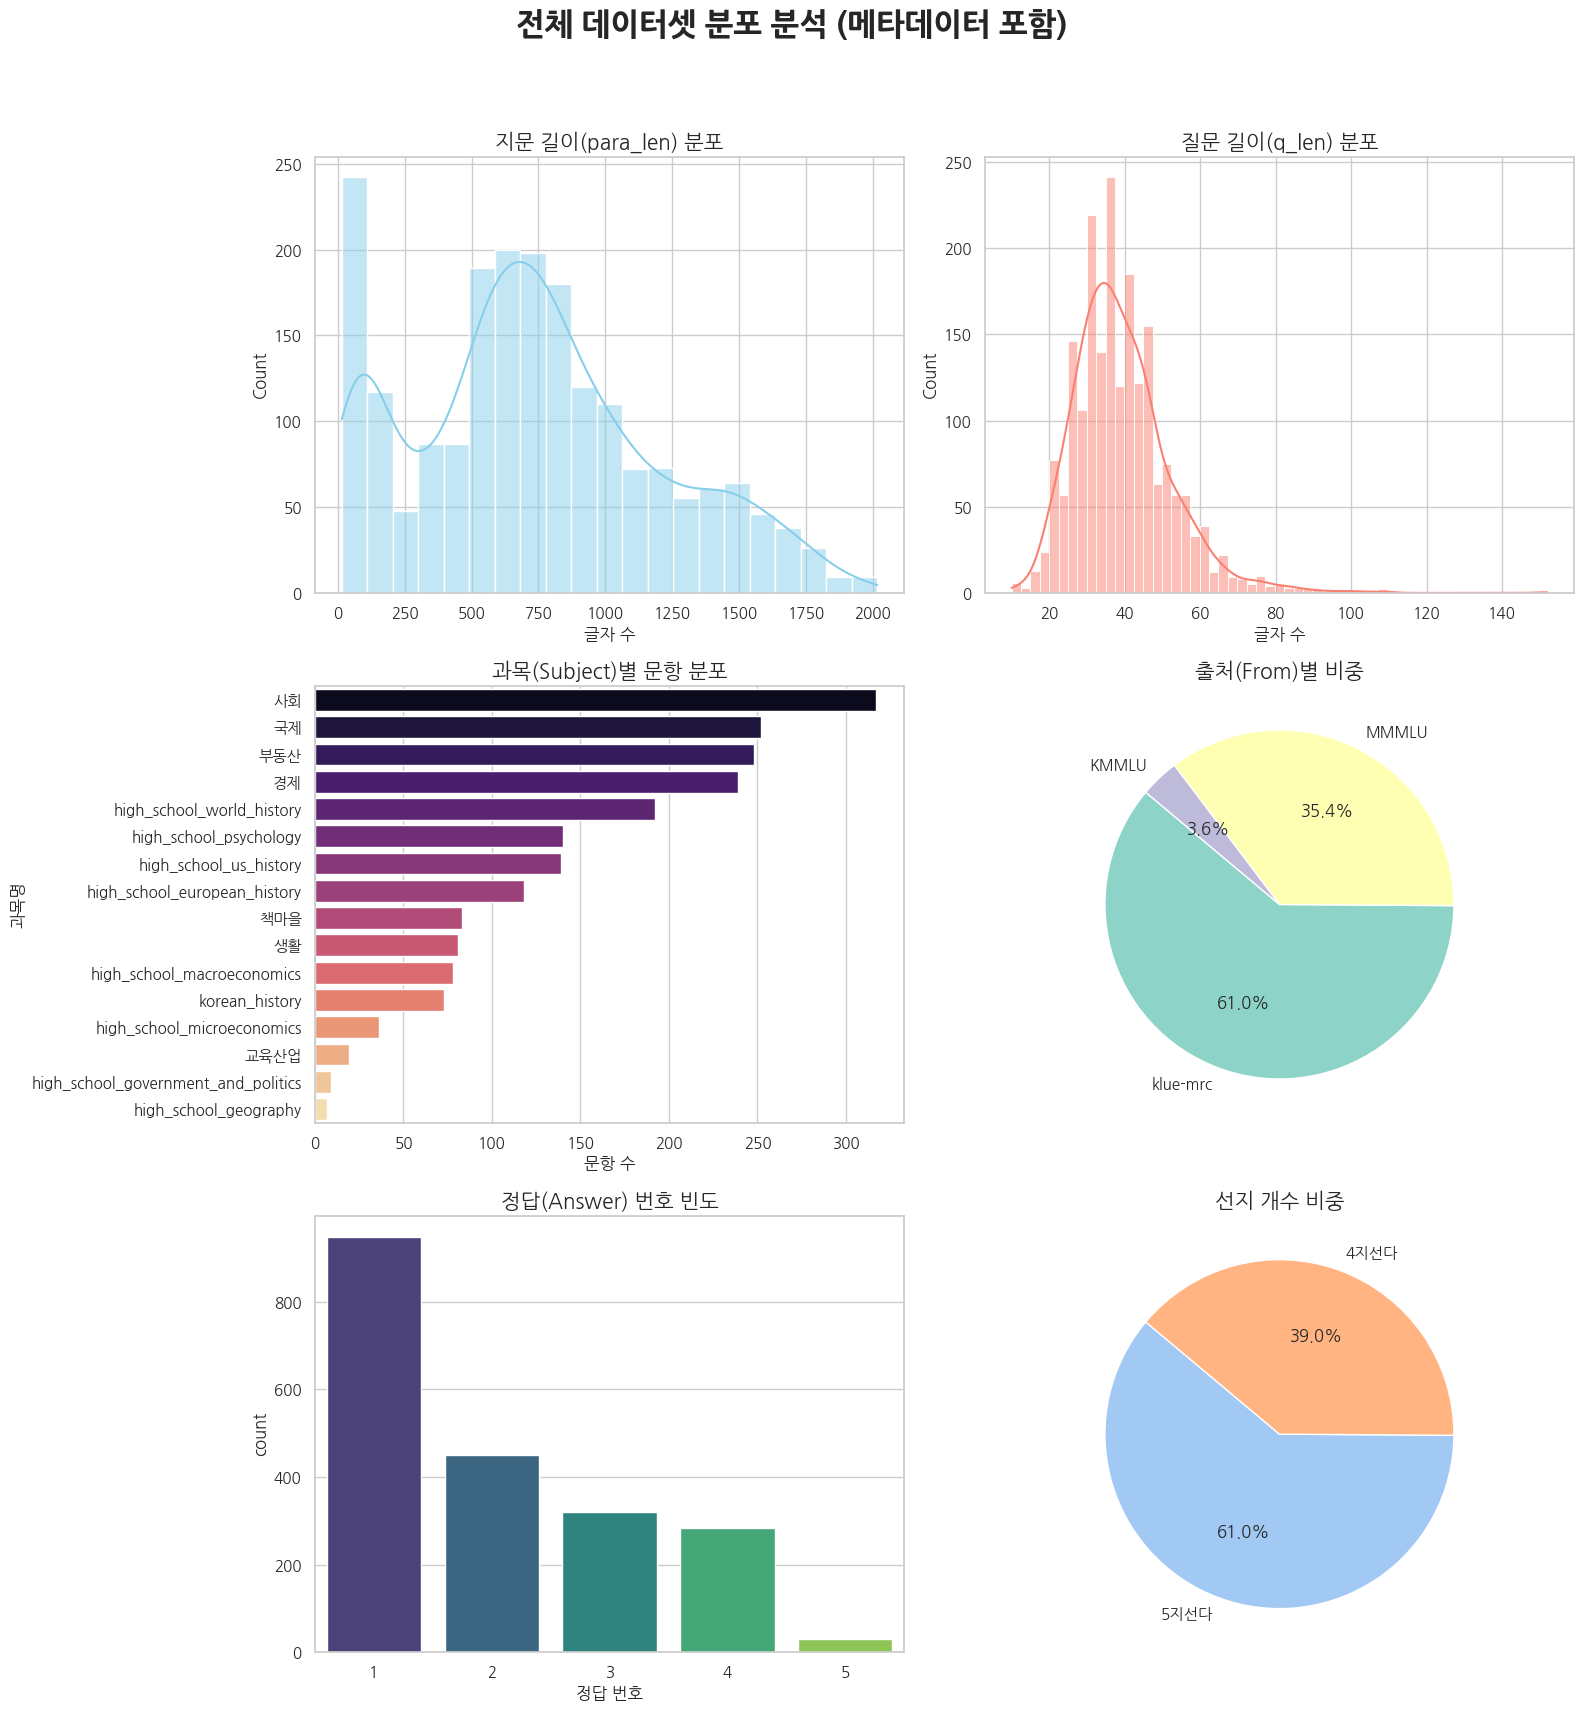

### 전체 데이터셋 주요 통계량 ###


,para_len,q_len,num_choices
count,2031.00,2031.00,2031.00
mean,735.33,39.24,4.61
std,462.59,12.98,0.49
min,15.00,10.00,4.00
25%,407.50,30.00,4.00
50%,699.00,37.00,5.00
75%,1014.50,46.00,5.00
max,2017.00,152.00,5.00



### 범주형 데이터 빈도 (Top 5) ###
------------------------------
[과목 분포]
 subject
사회                           317
국제                           252
부동산                          248
경제                           239
high_school_world_history    192
Name: count, dtype: int64

[출처 분포]
 from
klue-mrc    1239
MMMLU        719
KMMLU         73
Name: count, dtype: int64


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 1. 시각화할 피처 추가 계산
df_dist = df.copy()
df_dist['para_len'] = df_dist['paragraph'].apply(lambda x: len(str(x)) if x else 0)
df_dist['q_len'] = df_dist['question'].apply(lambda x: len(str(x)) if x else 0)
df_dist['num_choices'] = df_dist['choices'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 2. 서브플롯 구성 (3x2 레이아웃으로 변경)
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('전체 데이터셋 분포 분석 (메타데이터 포함)', fontsize=22, fontweight='bold', y=0.98)

# (1) 지문 길이 분포
sns.histplot(df_dist['para_len'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('지문 길이(para_len) 분포', fontsize=15)
axes[0, 0].set_xlabel('글자 수')

# (2) 질문 길이 분포
sns.histplot(df_dist['q_len'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('질문 길이(q_len) 분포', fontsize=15)
axes[0, 1].set_xlabel('글자 수')

# (3) [추가] 과목별 문항 수 (subject)
# 빈도가 높은 순서대로 정렬하여 표시
subject_order = df_dist['subject'].value_counts().index
sns.countplot(y='subject', data=df_dist, ax=axes[1, 0], order=subject_order, palette='magma')
axes[1, 0].set_title('과목(Subject)별 문항 분포', fontsize=15)
axes[1, 0].set_xlabel('문항 수')
axes[1, 0].set_ylabel('과목명')

# (4) [추가] 출처별 비중 (from) - 파이 차트
from_counts = df_dist['from'].value_counts()
axes[1, 1].pie(from_counts, labels=from_counts.index, 
                autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
axes[1, 1].set_title('출처(From)별 비중', fontsize=15)

# (5) 정답(answer) 번호 빈도
sns.countplot(x='answer', data=df_dist, ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('정답(Answer) 번호 빈도', fontsize=15)
axes[2, 0].set_xlabel('정답 번호')

# (6) 선지 개수 분포 - 파이 차트
choice_counts = df_dist['num_choices'].value_counts()
axes[2, 1].pie(choice_counts, labels=[f'{int(i)}지선다' for i in choice_counts.index], 
                autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes[2, 1].set_title('선지 개수 비중', fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. 주요 통계치 요약 출력 (subject와 from 빈도 포함)
print("### 전체 데이터셋 주요 통계량 ###")
summary = df_dist[['para_len', 'q_len', 'num_choices']].describe().round(2)
display(summary)

print("\n### 범주형 데이터 빈도 (Top 5) ###")
print("-" * 30)
print("[과목 분포]\n", df_dist['subject'].value_counts().head())
print("\n[출처 분포]\n", df_dist['from'].value_counts().head())

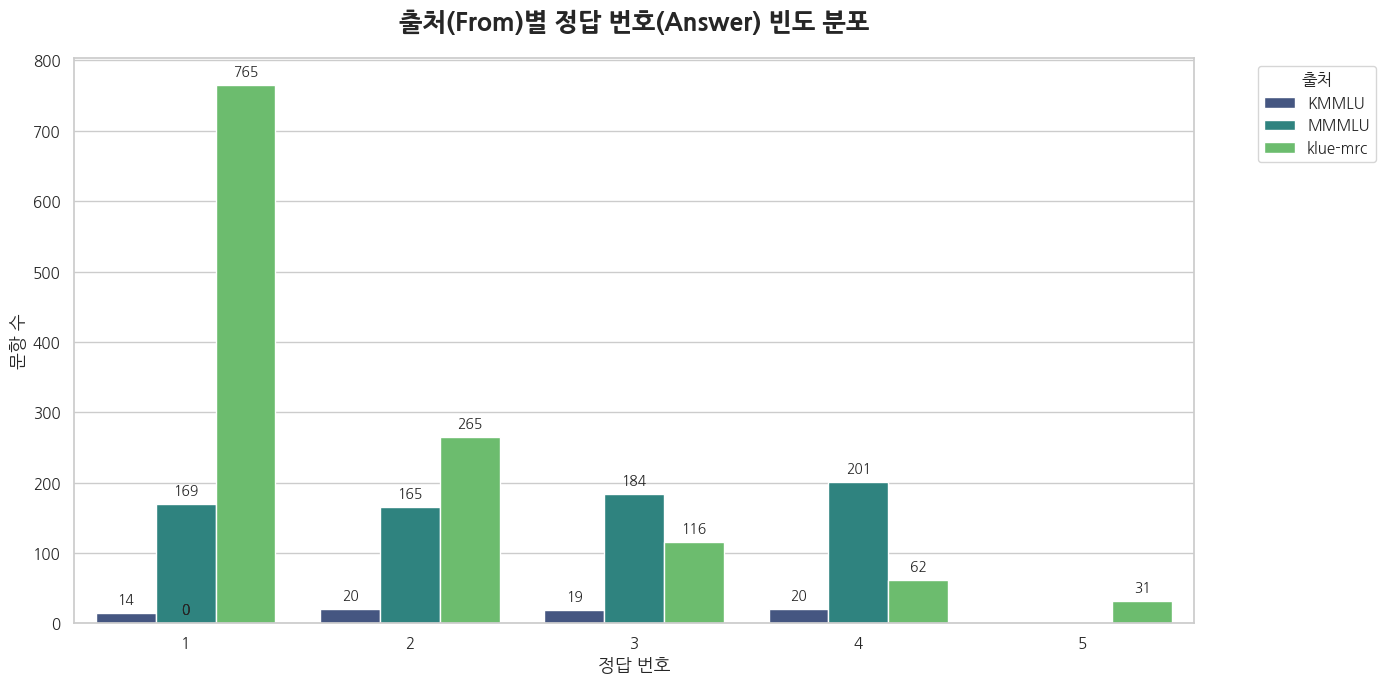

<<<출처별 정답 번호 상세 빈도표>>>


answer,1,2,3,4,5
from,,,,,
KMMLU,14,20,19,20,0
MMMLU,169,165,184,201,0
klue-mrc,765,265,116,62,31


In [44]:
# 출처 별 정답 빈도
# 1. 시각화 스타일 및 폰트 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우 한글 설정
plt.rcParams['axes.unicode_minus'] = False

# 2. 그래프 생성
plt.figure(figsize=(14, 7))

# hue='from'을 사용하여 정답 번호(1~5)별로 출처가 나란히 보이게 설정
ax = sns.countplot(x='answer', hue='from', data=df, palette='viridis')

# 3. 타이틀 및 라벨 설정
plt.title('출처(From)별 정답 번호(Answer) 빈도 분포', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('정답 번호', fontsize=13)
plt.ylabel('문항 수', fontsize=13)
plt.legend(title='출처', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례를 그래프 밖으로 이동

# 4. 막대 위에 숫자 표시 (선택 사항)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# 5. 수치 데이터로 확인 (Cross-tabulation)
print("<<<출처별 정답 번호 상세 빈도표>>>")
cross_tab = pd.crosstab(df['from'], df['answer'])
display(cross_tab)

In [32]:
import pandas as pd
import numpy as np
import re
from kiwipiepy import Kiwi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 초기화: 형태소 분석기 및 S-BERT 모델 로드
kiwi = Kiwi()
# 한국어 문맥 파악에 최적화된 모델 사용
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_all_advanced_features(row):
    p_text = str(row['paragraph']) if row['paragraph'] else ""
    q_text = str(row['question']) if row['question'] else ""
    
    if not p_text.strip():
        return pd.Series([0.0] * 9) 

    # --- [A] 기초 언어적 분석 ---
    sentences = kiwi.split_into_sents(p_text)
    num_sentences = len(sentences)
    words = p_text.split()
    avg_words_per_sent = len(words) / num_sentences if num_sentences > 0 else 0
    num_paragraphs = len([p for p in p_text.split('\n') if p.strip()])
    
    # --- [B] 형태소 분석 (Kiwi 사용) ---
    tokens = kiwi.tokenize(p_text)
    nouns = [t.form for t in tokens if t.tag.startswith('N')]
    unique_nouns = [n for n in nouns if len(n) >= 3] 
    modifiers = [t.form for t in tokens if t.tag in ['MM', 'MAG']]
    
    # --- [C] LQ 지수 관련 피처 ---
    ttr = len(set(nouns)) / len(nouns) if len(nouns) > 0 else 0
    term_density = len(unique_nouns) / len(words) if len(words) > 0 else 0
    modifier_ratio = len(modifiers) / len(words) if len(words) > 0 else 0
    lq_score = (avg_words_per_sent * 0.4) + (term_density * 30) + (modifier_ratio * 10) + (ttr * 5)
    
    # --- [D] 관계 및 질문 특징 피처 ---
    readability = (avg_words_per_sent * 0.5) + (len(set(nouns)) * 0.1)
    
    # 질문-지문 유사도 (S-BERT 임베딩 기반 코사인 유사도)
    try:
        p_embedding = model.encode([p_text])
        q_embedding = model.encode([q_text])
        
        # 코사인 유사도 계산
        q_p_similarity = cosine_similarity(p_embedding, q_embedding)[0][0]
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        q_p_similarity = 0.0
        
    # 부정 질문 여부
    negative_keywords = ['않은', '못한', '없는', '틀린', '아닌', '적절하지']
    is_negative = 1 if any(word in q_text for word in negative_keywords) else 0

    return pd.Series([
        avg_words_per_sent, num_paragraphs, ttr, term_density, 
        modifier_ratio, lq_score, readability, q_p_similarity, is_negative
    ])

# 2. 피처 생성 및 적용
new_cols = [
    'avg_words_per_sent', 'num_paragraphs', 'lq_ttr', 'lq_term_density', 
    'lq_modifier_ratio', 'lq_score', 'readability', 'q_p_similarity', 'is_negative'
]

print("S-BERT 임베딩 및 LQ 지수 피처 생성 중...")
df[new_cols] = df.apply(calculate_all_advanced_features, axis=1)

# 3. 결과 확인
print("\n### 피처 생성 결과 (S-BERT 기반 유사도 포함) ###")
display(df[['id', 'lq_score', 'q_p_similarity', 'is_negative']].head())

# 4. 통계 요약
display(df[new_cols].describe().round(4))

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


S-BERT 임베딩 및 LQ 지수 피처 생성 중...

### 피처 생성 결과 (S-BERT 기반 유사도 포함) ###


,id,lq_score,q_p_similarity,is_negative
0,generation-for-nlp-425,11.894186,0.467032,0.0
1,generation-for-nlp-426,15.480882,0.170359,1.0
2,generation-for-nlp-427,10.215086,0.262167,0.0
3,generation-for-nlp-428,18.656937,0.184196,0.0
4,generation-for-nlp-429,14.886751,0.337196,1.0


,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,readability,q_p_similarity,is_negative
count,2031.0000,2031.0000,2031.0000,2031.0000,2031.0000,2031.0000,2031.0000,2031.0000,2031.0000
mean,15.2392,1.1270,0.6834,0.1312,0.0569,14.0176,16.5194,0.4673,0.0379
std,7.1686,1.3155,0.1447,0.0715,0.0373,3.4538,6.8066,0.1806,0.1910
min,2.0000,1.0000,0.0000,0.0000,0.0000,4.0000,1.4000,0.0006,0.0000
25%,11.8000,1.0000,0.5793,0.0786,0.0335,12.0005,11.9592,0.3399,0.0000
50%,14.3636,1.0000,0.6591,0.1287,0.0507,13.7464,16.7417,0.4922,0.0000
75%,17.5000,1.0000,0.7738,0.1791,0.0740,15.6132,20.8755,0.5954,0.0000
max,120.0000,31.0000,1.0000,0.6000,0.3333,52.8167,65.1000,1.0000,1.0000


In [33]:
df.head(3)

,id,paragraph,question,choices,answer,question_plus,subject,from,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,readability,q_p_similarity,is_negative
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,12.466667,0.467032,0.0
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,9.600000,0.170359,1.0
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,6.800000,0.262167,0.0


In [34]:
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 모델 로드
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_smart_attractiveness(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [A] 지문 하단에서 ㄱ, ㄴ, ㄷ, ㄹ 문장 추출 ---
    # 패턴: ㄱ.으로 시작해서 다음 기호 전까지의 텍스트를 가져옴
    tag_content = {}
    tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
    for i in range(len(tags)-1):
        # 기호(ㄱ.) 뒤의 문장을 찾는 정규표현식
        pattern = f"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
        match = re.search(pattern, p_text, re.S)
        if match:
            tag_content[tags[i]] = match.group(1).strip()

    # --- [B] 선택지 텍스트 재구성 ---
    # 예: 'ㄱ, ㄴ' -> '기사환국으로 정권을 장악하였다. 인조반정을 주도하여 집권세력이 되었다.'
    refined_choices = []
    for c in choices:
        actual_text = ""
        for tag, content in tag_content.items():
            if tag in str(c):
                actual_text += content + " "
        # 기호를 못 찾았다면(일반 문제) 원래 선택지 텍스트 사용
        refined_choices.append(actual_text.strip() if actual_text else str(c))

    # --- [C] 의미론적 유사도 기반 매력도 계산 ---
    embeddings = model.encode(refined_choices)
    # 지문 전체(기호 부분 제외한 상단 내용)와의 유사도 분석을 위해 지문 임베딩
    main_p_text = re.sub(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)].*', '', p_text, flags=re.S) # 기호 부분 제거
    p_embedding = model.encode([main_p_text])
    
    answer_embedding = embeddings[answer_idx].reshape(1, -1)
    distractor_scores = []
    
    for i, c_emb in enumerate(embeddings):
        if i == answer_idx: continue
        
        c_emb = c_emb.reshape(1, -1)
        # 1. 정답과의 유사도 (말바꾸기 함정)
        sim_with_answer = cosine_similarity(c_emb, answer_embedding)[0][0]
        # 2. 본문과의 유사도 (키워드 낚시 함정)
        sim_with_para = cosine_similarity(c_emb, p_embedding)[0][0]
        
        distractor_scores.append(max(sim_with_answer, sim_with_para))
    
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 적용
df['distractor_attractiveness'] = df.apply(calculate_smart_attractiveness, axis=1)

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 모델 로드 (한국어 성능이 우수한 S-BERT 모델)
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_hybrid_attractiveness_sbert(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 조합형 문제 확인 및 텍스트 추출 ---
    # 지문에 'ㄱ.' 형태의 패턴이 있는지 검사
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))

    if is_combination:
        # 지문 하단 기호(ㄱ, ㄴ, ㄷ...) 뒤의 실제 텍스트 내용 추출
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match:
                tag_content[tags[i]] = match.group(1).strip()
        
        # 선택지 기호를 실제 문장으로 치환하여 합성
        processed_choices = []
        for c in choices:
            actual_text = ""
            for tag, content in tag_content.items():
                if tag in str(c):
                    actual_text += content + " "
            processed_choices.append(actual_text.strip() if actual_text else str(c))
    else:
        # 일반 문항은 선택지 텍스트 그대로 사용
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] S-BERT 임베딩 생성 ---
    # 선택지 전체를 벡터화
    choice_embeddings = model.encode(processed_choices)
    
    # 지문 텍스트 벡터화 (조합형인 경우 기호 부분 제외하고 본문만 추출)
    clean_p_text = re.sub(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)].*', '', p_text, flags=re.S) if is_combination else p_text
    p_embedding = model.encode([clean_p_text])
    
    # 정답 벡터 추출
    answer_embedding = choice_embeddings[answer_idx].reshape(1, -1)
    
    distractor_scores = []
    
    # --- [Step 3] 오답별 매력도 계산 ---
    for i, c_emb in enumerate(choice_embeddings):
        if i == answer_idx: 
            continue  # 정답은 계산에서 제외
        
        c_emb = c_emb.reshape(1, -1)
        
        # A) 정답과의 유사도 (재진술/말바꾸기 함정)
        sim_with_answer = cosine_similarity(c_emb, answer_embedding)[0][0]
        
        # B) 지문 본문과의 유사도 (단어 낚시 함정)
        sim_with_para = cosine_similarity(c_emb, p_embedding)[0][0]
        
        # 두 유사도 중 더 높은 것을 해당 오답의 '매력도'로 간주
        distractor_scores.append(max(sim_with_answer, sim_with_para))
    
    # 해당 문항에서 가장 매력적인 오답의 점수를 반환
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 2. 데이터프레임에 적용
print("S-BERT 하이브리드 모드로 오답 매력도 계산 중...")
df['distractor_attractiveness'] = df.apply(calculate_hybrid_attractiveness_sbert, axis=1)
print("계산 완료! 'distractor_attractiveness' 컬럼이 추가되었습니다.")

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


S-BERT 하이브리드 모드로 오답 매력도 계산 중...
계산 완료! 'distractor_attractiveness' 컬럼이 추가되었습니다.


In [36]:
import re
import numpy as np
import hashlib

def get_simhash(text):
    """텍스트의 SimHash 값을 64비트 정수로 생성"""
    if not text or len(str(text).strip()) == 0:
        return 0
    
    # 1. 특징 추출 (단어 단위 분절)
    features = str(text).split()
    v = [0] * 64  # 64비트 해시 벡터
    
    for f in features:
        # 각 단어의 고유 해시값 생성 (MD5 활용)
        t = int(hashlib.md5(f.encode('utf-8')).hexdigest(), 16)
        for i in range(64):
            bitmask = 1 << i
            if t & bitmask:
                v[i] += 1  # 비트가 1이면 가중치 증가
            else:
                v[i] -= 1  # 비트가 0이면 가중치 감소
                
    # 2. 결과 비트 생성
    fingerprint = 0
    for i in range(64):
        if v[i] >= 0:
            fingerprint |= (1 << i)
            
    return fingerprint

def get_hamming_similarity(hash1, hash2):
    """해밍 거리를 이용한 유사도 산출 (0~1 사이)"""
    # XOR 연산 후 1의 개수를 세어 해밍 거리를 구함
    x = hash1 ^ hash2
    hamming_dist = bin(x).count('1')
    # 64비트 기준 유사도로 변환 (거리가 0이면 유사도 1)
    return 1 - (hamming_dist / 64)

def calculate_simhash_attractiveness(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 하이브리드 텍스트 추출 (조합형 여부 판단) ---
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))
    processed_choices = []

    if is_combination:
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match: tag_content[tags[i]] = match.group(1).strip()
        
        for c in choices:
            actual_text = " ".join([tag_content[tag] for tag in tag_content if tag in str(c)])
            processed_choices.append(actual_text if actual_text else str(c))
    else:
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] SimHash 기반 유사도 계산 ---
    choice_hashes = [get_simhash(c) for c in processed_choices]
    p_hash = get_simhash(p_text)
    ans_hash = choice_hashes[answer_idx]
    
    distractor_scores = []
    for i, dist_hash in enumerate(choice_hashes):
        if i == answer_idx: continue
        
        # 정답 해시와 비교 + 지문 해시와 비교
        sim_with_ans = get_hamming_similarity(dist_hash, ans_hash)
        sim_with_p = get_hamming_similarity(dist_hash, p_hash)
        
        distractor_scores.append(max(sim_with_ans, sim_with_p))
        
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 데이터 적용
df['distractor_attractiveness_simhash'] = df.apply(calculate_simhash_attractiveness, axis=1)

In [37]:
df.head(3)

,id,paragraph,question,choices,answer,question_plus,subject,from,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,readability,q_p_similarity,is_negative,distractor_attractiveness,distractor_attractiveness_simhash
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,12.466667,0.467032,0.0,0.805455,0.703125
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,9.600000,0.170359,1.0,0.478597,0.656250
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,6.800000,0.262167,0.0,0.409381,0.656250


In [38]:
import pandas as pd

# 1. 선지 리스트의 길이를 계산하여 'num_choices' 열 생성
# choices 컬럼이 리스트 형태인 경우 len()을 사용하고, 
# 만약 결측치(NaN)가 있다면 0으로 처리합니다.
df['num_choices'] = df['choices'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 2. 결과 확인: 4지선다와 5지선다의 분포 확인
print("### 선지 개수별 문항 분포 ###")
print(df['num_choices'].value_counts().sort_index())

# 3. 데이터 샘플 확인
display(df[['id', 'choices', 'num_choices']].head())

### 선지 개수별 문항 분포 ###
num_choices
4     792
5    1239
Name: count, dtype: int64


,id,choices,num_choices
0,generation-for-nlp-425,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",4
1,generation-for-nlp-426,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",4
2,generation-for-nlp-427,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4
3,generation-for-nlp-428,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",4
4,generation-for-nlp-429,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",4


In [39]:
df.head()

,id,paragraph,question,choices,answer,question_plus,subject,from,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,readability,q_p_similarity,is_negative,distractor_attractiveness,distractor_attractiveness_simhash,num_choices
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,12.466667,0.467032,0.0,0.805455,0.703125,4
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,9.600000,0.170359,1.0,0.478597,0.656250,4
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,6.800000,0.262167,0.0,0.409381,0.656250,4
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU,29.000000,1.0,0.790698,0.068966,0.103448,18.656937,17.900000,0.184196,0.0,0.516401,0.750000,4
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU,19.000000,1.0,0.931034,0.052632,0.105263,14.886751,12.200000,0.337196,1.0,0.468751,0.656250,4


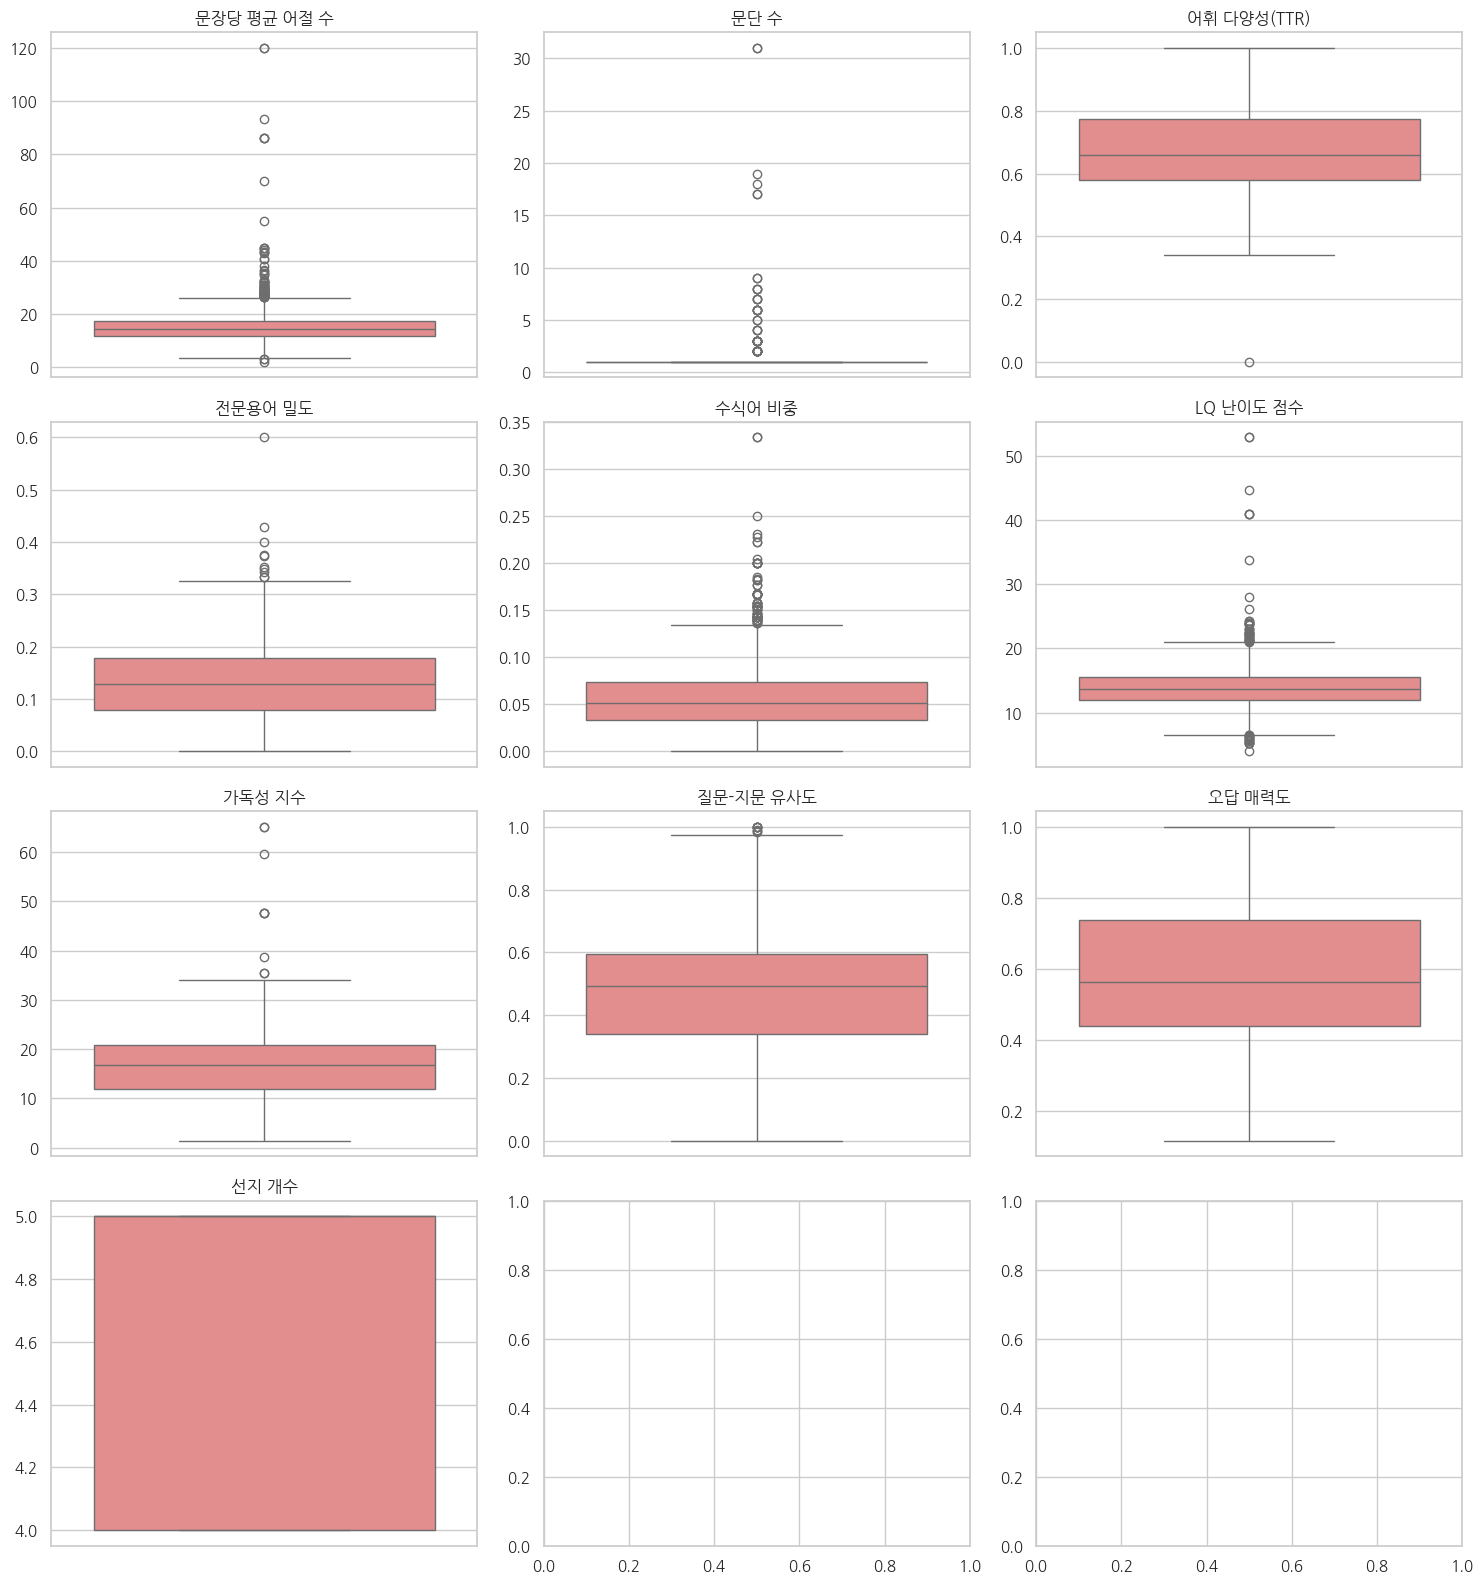

In [40]:
import seaborn as sns

# 한글 라벨 딕셔너리 (표시용)
korean_labels = {
    'avg_words_per_sent': '문장당 평균 어절 수',
    'num_paragraphs': '문단 수',
    'lq_ttr': '어휘 다양성(TTR)',
    'lq_term_density': '전문용어 밀도',
    'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도 점수',
    'readability': '가독성 지수',
    'q_p_similarity': '질문-지문 유사도',
    'distractor_attractiveness': '오답 매력도',
    'num_choices': '선지 개수'
}

# 시각화할 피처 리스트
features = list(korean_labels.keys())

# 서브플롯 설정
cols = 3
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    if col in df.columns:
        sns.boxplot(y=df[col], ax=axes[i], color='lightcoral')
        axes[i].set_title(korean_labels[col], fontsize=12) # 한글 타이틀 적용
        axes[i].set_ylabel('')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

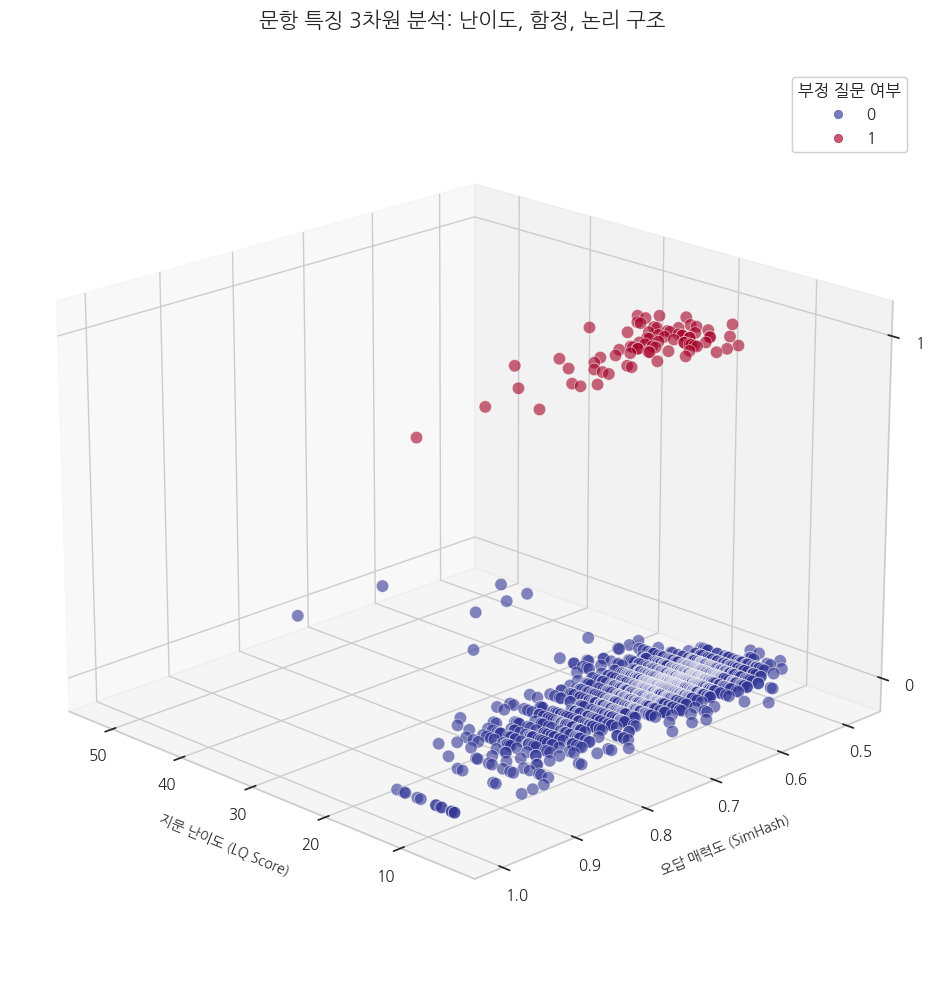

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# 1. 폰트 설정 (한글 깨짐 방지 - 시스템에 맞게 설정)
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우용
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥용
plt.rcParams['axes.unicode_minus'] = False

def plot_3d_final(df):
    # 그래프 크기 및 3D 축 설정
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 데이터 설정
    x = df['lq_score']
    y = df['distractor_attractiveness']
    z = df['is_negative']
    
    # 3차원 산점도 그리기
    # c=z: 부정 질문 여부(0, 1)에 따라 색상 부여 (Red-Blue 계열)
    scatter = ax.scatter(x, y, z, 
                         c=z, 
                         cmap='RdYlBu_r', 
                         s=80,             # 점 크기
                         alpha=0.6,        # 투명도
                         edgecolors='white', 
                         linewidth=0.5)
    
    # 축 라벨 설정
    ax.set_xlabel('지문 난이도 (LQ Score)', fontsize=10, labelpad=10)
    ax.set_ylabel('오답 매력도 (SimHash)', fontsize=10, labelpad=10)
    ax.set_zlabel('부정 질문 여부 (Is Negative)', fontsize=10, labelpad=10)
    
    # 타이틀
    plt.title('문항 특징 3차원 분석: 난이도, 함정, 논리 구조', fontsize=15, pad=30)
    
    # Z축(부정 질문) 눈금 조정 (0과 1만 표시)
    ax.set_zticks([0, 1])
    ax.set_zlim(-0.1, 1.1)
    
    # 범례 추가
    legend = ax.legend(*scatter.legend_elements(), title="부정 질문 여부", loc="upper right")
    ax.add_artist(legend)
    
    # 시각화 각도 최적화 (사용자가 마우스로 돌려볼 수 있습니다)
    ax.view_init(elev=20, azim=135)
    
    plt.tight_layout()
    plt.show()

# 실행
plot_3d_final(df)